In [17]:
!pip install -q dwave-ocean-sdk

## Problem Statement
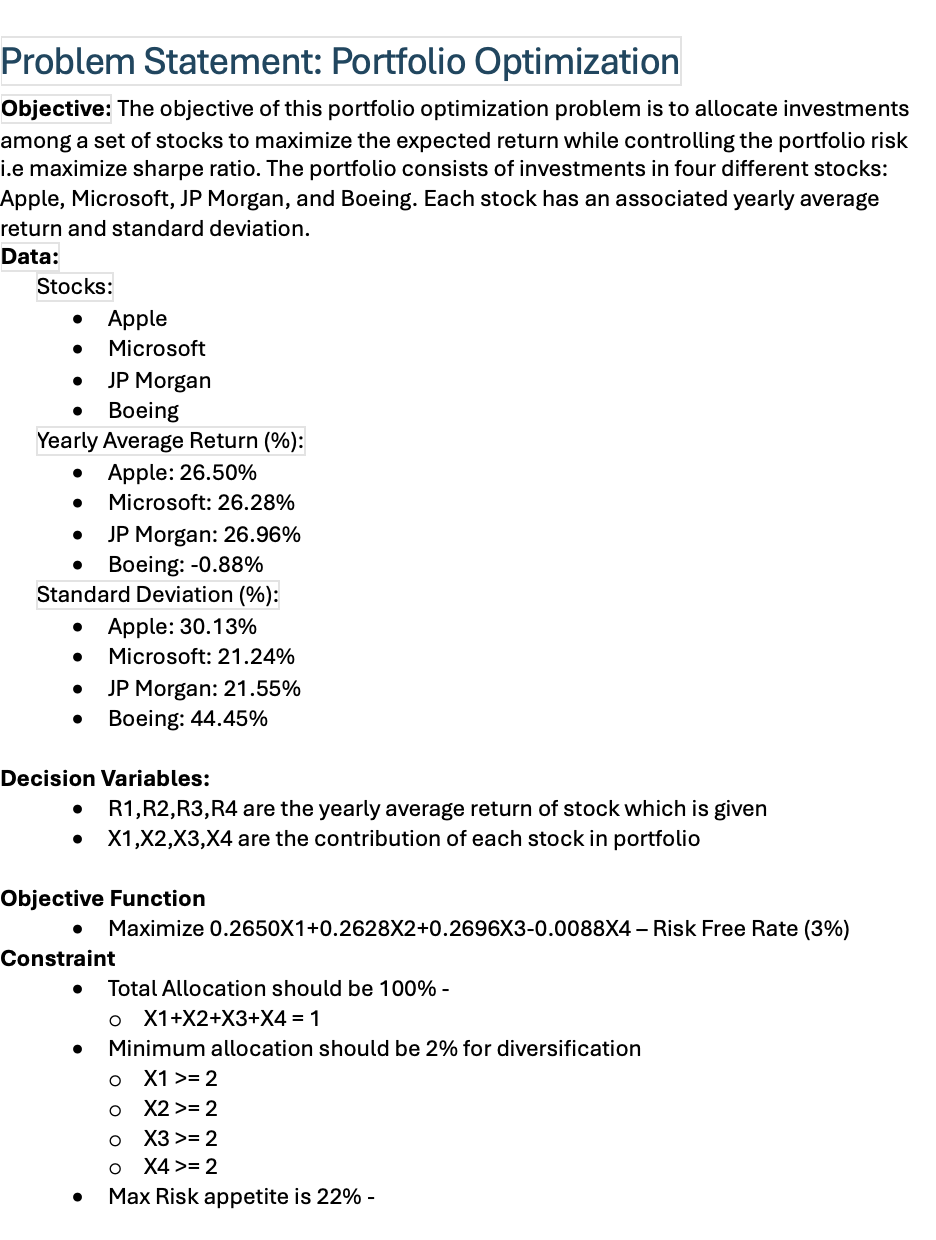

## Quantum Hybrid Optimizer D wave CQM (Constraint Quadratic Model)

In [52]:
from dimod import Integer
import neal
from dwave.system import (DWaveSampler, EmbeddingComposite,FixedEmbeddingComposite, LeapHybridDQMSampler, LeapHybridCQMSampler )

# Define the decision variables
stocks={'Apple': 0, 'Microsoft': 0, 'JP Morgan': 0, 'Boeing': 0}
x1 = Integer('x1')
x2 = Integer('x2')
x3 = Integer('x3')
x4 = Integer('x4')

# Total weighted return and total weighted risk
total_weighted_return = 0.2650 * x1 + 0.2628 * x2 + 0.2696 * x3 - 0.0088 * x4
total_weighted_risk = 0.3013 * x1 + 0.2124 * x2 + 0.2155 * x3 + 0.4445 * x4

# Create a ConstrainedQuadraticModel
cqm = dimod.ConstrainedQuadraticModel()

# Risk-free rate
risk_free_rate = 0.03  # Example risk-free rate
# Calculate excess return
excess_return = total_weighted_return - risk_free_rate

# Adding objective function to minimized or maximized
cqm.set_objective(excess_return)

# Adding constraint to model
cqm.add_constraint(x1 + x2 + x3 + x4 == 100,label='total allocation')
cqm.add_constraint(total_weighted_risk <=22 ,label='risk constraint')
min_allocation_percentage = 2  # Minimum 2% allocation for each stock
cqm.add_constraint(x1 >= min_allocation_percentage,label='x1 allocation')
cqm.add_constraint(x2 >= min_allocation_percentage,label='x2 allocation')
cqm.add_constraint(x3 >= min_allocation_percentage,label='x3 allocation')
cqm.add_constraint(x4 >= min_allocation_percentage,label='x4 allocation')

DWavesampler=EmbeddingComposite(DWaveSampler(solver='Advantage_system6.4',token='DEV-081b757ac8fa9601e4fd99a1710375235deaa0c4')) # using Dwave system
# Create an instance of the LeapHybridCQMSampler
sampler = LeapHybridCQMSampler(token='DEV-081b757ac8fa9601e4fd99a1710375235deaa0c4')

# Sample from the CQM
sample = sampler.sample_cqm(cqm, label="Example - Portfolio Optimization")
# sample.record
energies = sample.data_vectors['energy']
mit = max(energies) # taking optimum or minimum energy solution
print(mit)
X_list =[]
for sample, energy, num_occ in sample.data(['sample', 'energy', 'num_occurrences']):
  if (energy==mit):
     X_list.append(list(sample.values()))
print(X_list)

# Update the allocation values with the values from X_list
for i, stock in enumerate(stocks):
    stocks[stock] = X_list[0][i]

# Calculate final return using the allocation values
final_return = 0.2650 * stocks['Apple'] + 0.2628 * stocks['Microsoft'] + 0.2696 * stocks['JP Morgan'] - 0.0088 * stocks['Boeing']

# Calculate final risk using the allocation values
final_risk = 0.3013 * stocks['Apple'] + 0.2124 * stocks['Microsoft'] + 0.2155 * stocks['JP Morgan'] + 0.4445 * stocks['Boeing']

# Calculate Sharpe ratio
sharpe_ratio = final_return / final_risk

# Print results
print("Return:", final_return)
print("Risk:", final_risk)
print("Sharpe Ratio:", sharpe_ratio)
print("allocation with stock",stocks)


26.2484
[[2.0, 17.0, 79.0, 2.0]]
Return: 26.278399999999998
Risk: 22.1269
Sharpe Ratio: 1.1876223058810769
allocation with stock {'Apple': 2.0, 'Microsoft': 17.0, 'JP Morgan': 79.0, 'Boeing': 2.0}


### Classical Optimizer GLOP CBC

In [32]:
!pip install -q ortools

In [53]:
from ortools.linear_solver import pywraplp

# Create the linear solver with the GLOP backend made by Google.
solver = pywraplp.Solver.CreateSolver('CBC')
# solver = pywraplp.Solver.CreateSolver('GLOP')

# Adding variables (percentage allocations)
x1 = solver.IntVar(0, 100, 'x1')
x2 = solver.IntVar(0, 100, 'x2')
x3 = solver.IntVar(0, 100, 'x3')
x4 = solver.IntVar(0, 100, 'x4')

# Total weighted return and total weighted risk
total_weighted_return = 0.2650 * x1 + 0.2628 * x2 + 0.2696 * x3 - 0.0088 * x4
total_weighted_risk = 0.3013 * x1 + 0.2124 * x2 + 0.2155 * x3 + 0.4445 * x4

# Adding constraint: total allocation equals 100%
solver.Add(x1 + x2 + x3 + x4 == 100)

# Adding constraint: minimum allocation percentage for each stock
min_allocation_percentage = 2  # Minimum 20% allocation for each stock
solver.Add(x1 >= min_allocation_percentage)
solver.Add(x2 >= min_allocation_percentage)
solver.Add(x3 >= min_allocation_percentage)
solver.Add(x4 >= min_allocation_percentage)

# Calculate expected return and risk
expected_return = total_weighted_return
portfolio_risk = total_weighted_risk

# Risk-free rate
risk_free_rate = 0.03  # Example risk-free rate

# Calculate excess return
excess_return = expected_return - risk_free_rate

# Add a new variable for portfolio risk and minimize it
portfolio_risk_var = solver.IntVar(0, solver.infinity(), 'portfolio_risk_var')
solver.Add(portfolio_risk <=22 )

# Maximize excess return while minimizing portfolio risk
solver.Maximize(excess_return)

# Solve the problem
result = solver.Solve()

# Check if it is optimal
if result == pywraplp.Solver.OPTIMAL:
    print('Optimal Found')

# Print the solution
print('x1:', x1.solution_value())
print('x2:', x2.solution_value())
print('x3:', x3.solution_value())
print('x4:', x4.solution_value())
final_return_classical = 0.2650 * x1.solution_value() + 0.2628 * x2.solution_value() + 0.2696 * x3.solution_value() - 0.0088 * x4.solution_value()
final_risk_classical =0.3013 * x1.solution_value() + 0.2124 * x2.solution_value() + 0.2155 * x3.solution_value() + 0.4445 * x4.solution_value()
sharpe_ratio_classical =  final_return_classical/final_risk_classical
print("return", final_return_classical)
print("risk", final_risk_classical)
print("sharpe ratio", sharpe_ratio_classical)
print("allocation with stock",{'Apple': x1.solution_value(), 'Microsoft': x2.solution_value(), 'JP Morgan': x3.solution_value(), 'Boeing': x4.solution_value()})

Optimal Found
x1: 2.0
x2: 58.0
x3: 38.0
x4: 2.0
return 25.999599999999994
risk 21.9998
sharpe ratio 1.1818107437340337
allocation with stock {'Apple': 2.0, 'Microsoft': 58.0, 'JP Morgan': 38.0, 'Boeing': 2.0}


### Compare result

In [54]:
## Quantum
print("------------Quantum Solution --------------------")
print("Return:", final_return)
print("Risk:", final_risk)
print("Sharpe Ratio:", sharpe_ratio)
print("allocation with stock",stocks)
print("================================================")
print("================================================")
## Classical GLOP
print("------------Classical Solution --------------------")
print("return", final_return_classical)
print("risk", final_risk_classical)
print("sharpe ratio", sharpe_ratio_classical)
stocks_classical = {'Apple': x1.solution_value(), 'Microsoft': x2.solution_value(), 'JP Morgan': x3.solution_value(), 'Boeing': x4.solution_value()}
print("allocation with stock",stocks_classical)
print("================================================")
print("Return Difference",final_return - final_return_classical )
print("Risk Difference",final_risk - final_risk_classical )
print("Sharpe Ratio difference",sharpe_ratio - sharpe_ratio_classical)

------------Quantum Solution --------------------
Return: 26.278399999999998
Risk: 22.1269
Sharpe Ratio: 1.1876223058810769
allocation with stock {'Apple': 2.0, 'Microsoft': 17.0, 'JP Morgan': 79.0, 'Boeing': 2.0}
------------Classical Solution --------------------
return 25.999599999999994
risk 21.9998
sharpe ratio 1.1818107437340337
allocation with stock {'Apple': 2.0, 'Microsoft': 58.0, 'JP Morgan': 38.0, 'Boeing': 2.0}
Return Difference 0.27880000000000393
Risk Difference 0.12709999999999866
Sharpe Ratio difference 0.005811562147043148
